# Emojifier

Selecting the best emoji for a sentence using LSTM's and word embeddings.

_PyTorch implementation of the assignment of Course 5 of Coursera's Deep Learning Specialization_.

## Imports

In [1]:
%matplotlib inline

import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

## Reproducibility

In [2]:
seed = 24
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset

We will create a custom dataset that will provide the following:

- Each sample is a sentence, represented as an array of word indices where each index comes from a vocabulary provided by GloVe vectors
- Each corresponding target is the index of the emoji that best matches the sentence
- 132 training examples
- 55 testing examples

The following image shows an example of what the dataset looks like.

![](img/emoji_dataset.png)

### GloVe Vectors

We will use pre-trained GloVe vectors that can be downloaded from the [official site](https://nlp.stanford.edu/projects/glove/). Specifically, we will use the `glove.6B.50d.txt` file (6B tokens and vectors of dimension 50) from the `glove.6b.zip` file. We will define two dictionaries to map a word to its GloVe index, and an index to its GloVe vectors. As part of this dictionaries we will add an extra entry for the `<PAD>` value used for padding the sentences to be of equal length.

_Note: See this [blog post](https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76) for an explanation on how to use GloVe vectors in Pytorch._

In [4]:
word_to_ix = {}
vectors = {}

with open('data/glove.6B.50d.txt', 'r') as f:
    words = set()
    vectors = {}

    for i, line in enumerate(f):
        line = line.strip().split()
        word = line[0]
        vectors[i] = np.array(line[1:], dtype=np.float64)
        word_to_ix[word] = i

# Add the padding value
word_to_ix['<PAD>'] = len(word_to_ix)

In [5]:
def collate_fn(batch):
    # We define a custom collate_fn so that we can pad the sentences to have the same length
    # See: https://ryankresse.com/dealing-with-pad-tokens-in-sequence-models-loss-masking-and-pytorchs-packed-sequence/
    sentences, labels = zip(*batch)

    # Compute the original lengths which will be useful for packing the padded sequence
    lengths = [len(s) for s in sentences]
    # Pad sentences into batch of shape (batch_size, max_len)
    sentences = nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=word_to_ix['<PAD>'])
    
    # Merge labels into batch of shape (batch_size,)
    labels = torch.stack(labels, 0)
   
    return sentences, labels, lengths


class EmojiDataset(Dataset):
    def __init__(self, mode='train'):
        dataset = pd.read_csv(f'data/{mode}_emoji.csv', header=None)
        self.X = [torch.tensor([word_to_ix[w] for w in s.strip().lower().split()]) for s in dataset[0].values]
        self.y = dataset[1].values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.X[idx]
        y = torch.tensor(self.y[idx]).long()

        return X, y

For display purposes, we define a dictionary of labels to the actual emoji symbols. This is the same as the one used in the Deep Learning Specialization assignment.

In [6]:
label_to_emoji = {
    '0': '\u2764\uFE0F',  # :heart: prints a black instead of red heart depending on the font
    '1': ':baseball:',
    '2': ':smile:',
    '3': ':disappointed:',
    '4': ':fork_and_knife:'
}

We can now create the training and testing sets.

In [7]:
training = DataLoader(EmojiDataset(mode='train'), batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
testing = DataLoader(EmojiDataset(mode='test'), batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)

## Model

We'll use an LSTM with the following structure:

- An embedding layer that converts the indices of a sentence into GloVe vectors of dimension 50
- A first LSTM layer with 128 units followed by a Dropout layer
- A second LSTM layer with 128 units
- One single output, at the last timestep, that follows the LSTM cell with a Dropout layer and a softmax output function

This structure means our model is of type **sequence-to-one**; producing one single output after having processed the input sequence $T_x$.

![](img/model.png)

In [8]:
# The embedding layer generated from the pre-trained GloVe vectors
# See: https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
class GloVeEmbedding(nn.Module):
    def __init__(self):
        super(GloVeEmbedding, self).__init__()

        # Generate the matrix of weights as a lookup table from word indices to the GloVe vectors
        weights = np.zeros((len(word_to_ix), 50))
        for _, idx in word_to_ix.items():
            # If the index is not in GloVe (e.g. the padding value) we use all zeros
            weights[idx, :] = vectors[idx] if idx in vectors else np.zeros(50)

        # Instantiate the pre-trained embedding
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(weights).float())

    def forward(self, input):
        return self.embedding(input)


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.embedding = GloVeEmbedding()
        # The first LSTM layer expects sequences of size `embedding_size=50`
        self.lstm = nn.LSTM(input_size=50, hidden_size=128, num_layers=2, dropout=0.5, batch_first=True)
        # This dropout will be used for the output since PyTorch doesn't introduce a dropout layer after the last LSTM layer
        # See: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
        self.dropout = nn.Dropout(p=0.5)
        # Output layer to convert to target space (5 different emojis)
        self.out = nn.Linear(in_features=128, out_features=5)
        # We don't define a softmax output layer explicitly because it's combined with the loss function

    def forward(self, input, lengths):
        # Embed
        embeddings = self.embedding(input)
        # Pack the padded sequence so that the layers ignore the padded values during backprop
        # See: https://ryankresse.com/dealing-with-pad-tokens-in-sequence-models-loss-masking-and-pytorchs-packed-sequence/
        packed = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        # Pass through LSTM
        # The activations are not passed in so that they are initialized to zero; we don't need to pass the previous activations
        # because we are training in batches which allows the model to learn enough before the state is re-initialized;
        # if we were training using a single example then we would need to pass the previous state (like we did in the dinosaur name
        # generation project) because with one example the model can't learn enough for the state to be reset every time
        hiddens, state = self.lstm(packed)
        # Apply dropout to the output at timestep T of the last layer
        h_T, _ = state
        h_T = self.dropout(h_T[-1, :, :])
        # Convert to target space
        output = self.out(h_T)

        return output

In [9]:
model = Model()
print(model)

Model(
  (embedding): GloVeEmbedding(
    (embedding): Embedding(400001, 50)
  )
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=128, out_features=5, bias=True)
)


## Optimization

We'll use Adam for training the model with the cross-entropy loss.

In [10]:
loss_fn =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Training

Time to train the model!

In [11]:
# Training configuration
epochs = 40

[0/40]	Loss: 1.5671966075897217
[1/40]	Loss: 1.4753220081329346
[2/40]	Loss: 1.1786296367645264
[3/40]	Loss: 1.1316914558410645
[4/40]	Loss: 1.1219285726547241
[5/40]	Loss: 0.8289729356765747
[6/40]	Loss: 0.634110689163208
[7/40]	Loss: 0.560330867767334
[8/40]	Loss: 0.5661546587944031
[9/40]	Loss: 0.6716629862785339
[10/40]	Loss: 0.3340730369091034
[11/40]	Loss: 0.30723971128463745
[12/40]	Loss: 0.2479889839887619
[13/40]	Loss: 0.16478204727172852
[14/40]	Loss: 0.14478492736816406
[15/40]	Loss: 0.1768120974302292
[16/40]	Loss: 0.13828134536743164
[17/40]	Loss: 0.11401889473199844
[18/40]	Loss: 0.10209661722183228
[19/40]	Loss: 0.08762462437152863
[20/40]	Loss: 0.032750204205513
[21/40]	Loss: 0.06966733187437057
[22/40]	Loss: 0.05570991709828377
[23/40]	Loss: 0.03655354306101799
[24/40]	Loss: 0.023768045008182526
[25/40]	Loss: 0.015164835378527641
[26/40]	Loss: 0.01278142910450697
[27/40]	Loss: 0.0065477630123496056
[28/40]	Loss: 0.01093561016023159
[29/40]	Loss: 0.016081945970654488
[3

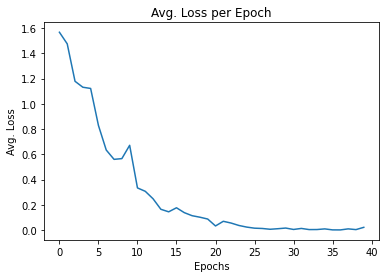

In [12]:
# Main training loop
model = model.to(device)
total_losses = []

for epoch in range(epochs):
    losses = []

    for samples, targets, lengths in training:
        optimizer.zero_grad()

        samples = samples.to(device)
        targets = targets.to(device)

        output = model(samples, lengths)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        
        # Detach the loss to avoid saving any more computations on it
        losses.append(loss.detach().cpu().numpy())

    total_losses.append(np.mean(losses))
    print(f'[{epoch}/{epochs}]\tLoss: {total_losses[-1]}')

# Save the model
torch.save(model.state_dict(), 'model/model.pt')

# Plot the losses
plt.plot(np.squeeze(total_losses))
plt.ylabel('Avg. Loss')
plt.xlabel('Epochs')
plt.title('Avg. Loss per Epoch')
plt.show()

## Testing

Now that we have trained our model, we can evaluate it against the testing set.

In [13]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load('model/model.pt'))
# Always set the mode to `eval` for inference
model.eval()
model = model.to(device)

accuracies = []

# Main inference loop
with torch.no_grad():
    for samples, targets, lengths in testing:
        output = model(samples.to(device), lengths)

        # Compute the probabilities of each emoji label via softmax
        probs = F.softmax(output, dim=-1)
        # Use the label of the highest probability
        preds = np.argmax(probs.detach().cpu().numpy(), axis=-1)

        # Remove extra dimension, i.e. flatten as vector
        targets = np.squeeze(targets.detach().cpu().numpy())

        # Evaluate using accuracy
        accuracies.append(np.mean(preds == targets))

print(f'Accuracy = {np.mean(accuracies)}')

Accuracy = 0.8854166666666667


Finally, let's try it with our own example.

In [14]:
sentence = 'great news'
input = torch.tensor([word_to_ix[w] for w in sentence.strip().lower().split()])
# Add `batch_size=1` dimension
input = input.unsqueeze(0)

with torch.no_grad():
    output = model(input.to(device), [len(sentence)])
    probs = F.softmax(output, dim=-1)
    label = np.argmax(probs.detach().cpu().numpy())

print(f'{sentence} {emoji.emojize(label_to_emoji[str(label)], use_aliases=True)}')

great news 😄
